# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}



# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [1]:
!pip install -q "scikit-learn==1.5.2" catboost category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import time

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.target_encoder import TargetEncoder

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [6]:
valid_values = {
    "experience_level": {"SE", "MI", "EN", "EX"},
    "employment_type": {"FT", "PT", "CT", "FL"},
    "remote_ratio": {0, 50, 100},
    "company_size": {"S", "M", "L"}
}

In [7]:
invalid_values = {col: set(df[col].unique()) - valid_set for col, valid_set in valid_values.items()}
invalid_values = {col: vals for col, vals in invalid_values.items() if vals}
invalid_values

{}

Лишних значений нет

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [8]:
# Проверка на пропущенные значения
missing_values = df.isnull().sum()
missing_values

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


Пропущенных значений нет

In [9]:
# Проверка на дубликаты
duplicates = df.duplicated().sum()
duplicates

1171

Обаружены полные дубликаты - надо изучить

In [10]:
df[df.duplicated()]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
115,2023,SE,FT,Data Scientist,150000,USD,150000,US,0,US,M
123,2023,SE,FT,Analytics Engineer,289800,USD,289800,US,0,US,M
153,2023,MI,FT,Data Engineer,100000,USD,100000,US,100,US,M
154,2023,MI,FT,Data Engineer,70000,USD,70000,US,100,US,M
160,2023,SE,FT,Data Engineer,115000,USD,115000,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
3439,2022,MI,FT,Data Scientist,78000,USD,78000,US,100,US,M
3440,2022,SE,FT,Data Engineer,135000,USD,135000,US,100,US,M
3441,2022,SE,FT,Data Engineer,115000,USD,115000,US,100,US,M
3586,2021,MI,FT,Data Engineer,200000,USD,200000,US,100,US,L


Дубликатов много, но для корректности работы удалим их

In [11]:
df = df.drop_duplicates()

In [12]:
# Проверка типов данных
data_types = df.dtypes
data_types

,0
work_year,int64
experience_level,object
employment_type,object
job_title,object
salary,int64
salary_currency,object
salary_in_usd,int64
employee_residence,object
remote_ratio,int64
company_location,object


In [13]:
# Проверка на аномальные значения в числовых данных
numeric_summary = df.describe()
numeric_summary

,work_year,salary,salary_in_usd,remote_ratio
count,2584.000000,2.584000e+03,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746
std,0.749179,8.080375e+05,67136.837329,48.163707
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


Аномальные значения присутствуют в зарплате. Учитывая сферу IT, это не удивительно

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

Столбцы salary и salary_currency нам не нужны, у нас имеется столбец salary_in_usd

In [14]:
df = df.drop(columns=["salary", "salary_currency"])

In [15]:
# Проверка количества уникальных значений в категориальных признаках
categorical_columns = ["job_title", "employee_residence", "company_location"]
unique_counts = {col: df[col].nunique() for col in categorical_columns}

unique_counts

{'job_title': 93, 'employee_residence': 78, 'company_location': 72}

Релокации участников опроса больше, чем стран. Также видим больше количество категорий, уменьшим их

In [16]:
def replace_rare_categories(df, column, top_n=15):
    top_categories = df[column].value_counts().nlargest(top_n).index
    df[column] = df[column].apply(lambda x: x if x in top_categories else "other")
    return df

In [17]:
for col in categorical_columns:
    df = replace_rare_categories(df, col)

In [18]:
{col: df[col].value_counts() for col in categorical_columns}

{'job_title': job_title
 Data Engineer                 598
 Data Scientist                538
 Data Analyst                  396
 other                         386
 Machine Learning Engineer     206
 Analytics Engineer             91
 Research Scientist             65
 Data Architect                 64
 Data Science Manager           52
 ML Engineer                    34
 Research Engineer              33
 Applied Scientist              31
 Machine Learning Scientist     26
 Data Manager                   23
 Data Science Consultant        23
 Computer Vision Engineer       18
 Name: count, dtype: int64,
 'employee_residence': employee_residence
 US       1893
 other     158
 GB        150
 CA         81
 IN         70
 ES         47
 DE         47
 FR         37
 PT         18
 BR         18
 NL         15
 GR         13
 AU         11
 MX         10
 PK          8
 IT          8
 Name: count, dtype: int64,
 'company_location': company_location
 US       1929
 GB        155
 other    

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [19]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [20]:
# Выделение числовых признаков
num_features = ["work_year", "remote_ratio"]
X_train_num = train_df[num_features]
X_test_num = test_df[num_features]

# Выделение числовых + категориальных признаков
cat_features = ["experience_level", "employment_type", "job_title",
                "employee_residence", "company_location", "company_size"]
X_train_full = train_df[num_features + cat_features]
X_test_full = test_df[num_features + cat_features]

# Целевая переменная
y_train = train_df["salary_in_usd"]
y_test = test_df["salary_in_usd"]

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [21]:
# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_num, y_train)

# Предсказания
y_pred = model.predict(X_test_num)

# Оценка качества модели
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mape, rmse

(0.829056639955772, 64000.532625649634)

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [22]:
# Обучение модели XGBoost
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train_num, y_train)

# Предсказания
y_pred_xgb = model_xgb.predict(X_test_num)

# Оценка качества модели
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

mape_xgb, rmse_xgb

(0.770844383416886, 62433.34778407533)

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [23]:
# OHE Encoding
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train_full[cat_features])
X_test_ohe = ohe.transform(X_test_full[cat_features])

X_train_ohe = np.hstack([X_train_num, X_train_ohe])
X_test_ohe = np.hstack([X_test_num, X_test_ohe])

# Label Encoding
le = {col: LabelEncoder().fit(X_train_full[col]) for col in cat_features}
X_train_le = X_train_full.copy()
X_test_le = X_test_full.copy()

for col in cat_features:
    X_train_le[col] = le[col].transform(X_train_le[col])
    X_test_le[col] = le[col].transform(X_test_le[col])

# Mean Target Encoding
te = TargetEncoder()
X_train_te = X_train_full.copy()
X_test_te = X_test_full.copy()

X_train_te[cat_features] = te.fit_transform(X_train_full[cat_features], y_train)
X_test_te[cat_features] = te.transform(X_test_full[cat_features])

# Функция обучения и оценки моделей
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model_lr = LinearRegression()
    model_xgb = XGBRegressor(random_state=42)

    model_lr.fit(X_train, y_train)
    model_xgb.fit(X_train, y_train)

    y_pred_lr = model_lr.predict(X_test)
    y_pred_xgb = model_xgb.predict(X_test)

    metrics_lr = (mean_absolute_percentage_error(y_test, y_pred_lr),
                  np.sqrt(mean_squared_error(y_test, y_pred_lr)))

    metrics_xgb = (mean_absolute_percentage_error(y_test, y_pred_xgb),
                   np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

    return metrics_lr, metrics_xgb

# Оценка моделей
metrics_ohe = train_and_evaluate(X_train_ohe, X_test_ohe, y_train, y_test)
metrics_le = train_and_evaluate(X_train_le, X_test_le, y_train, y_test)
metrics_te = train_and_evaluate(X_train_te, X_test_te, y_train, y_test)

metrics_ohe, metrics_le, metrics_te

(((0.46410484832478655, 52322.53348727282),
  (0.5312282606077596, 56861.41698921932)),
 ((0.6639349581055338, 58765.307154821734),
  (0.5010804150373663, 56491.640782713686)),
 ((0.438767707793778, 51549.22901239298),
  (0.484314400082223, 55153.35054323803)))

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [24]:
# Лучшая модель — Mean Target Encoding с бустингом (XGBoost)
best_model = XGBRegressor(random_state=42)
best_model.fit(X_train_te, y_train)

# Предсказания
y_pred_best = best_model.predict(X_test_te)

# Вычисление абсолютной ошибки
errors = abs(y_test - y_pred_best)

# Создание DataFrame с ошибками
error_df = test_df.copy()
error_df["predicted_salary"] = y_pred_best
error_df["absolute_error"] = errors

# Вывод топ-20 примеров с наибольшей ошибкой
error_df_top20 = error_df.sort_values(by="absolute_error", ascending=False).head(20)

In [25]:
error_df_top20

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,predicted_salary,absolute_error
2011,2022,MI,FT,Data Analyst,430967,GB,0,GB,M,57567.707031,373399.292969
1288,2023,SE,FT,Data Analyst,385000,US,0,US,M,128943.500000,256056.500000
3713,2020,SE,FT,Data Scientist,120000,US,50,US,L,339133.531250,219133.531250
3549,2020,EN,FT,Machine Learning Engineer,138000,US,100,US,S,312586.187500,174586.187500
1695,2023,SE,FT,Applied Scientist,72000,US,0,US,L,238386.656250,166386.656250
3155,2022,MI,FT,other,200000,IN,100,US,L,40201.343750,159798.656250
2406,2022,SE,FT,Data Engineer,315000,US,100,US,M,160023.000000,154977.000000
3517,2020,SE,FT,Data Scientist,68428,GR,100,US,L,220628.859375,152200.859375
2022,2022,SE,FT,other,10000,CA,50,other,S,158587.343750,148587.343750
779,2023,SE,FT,ML Engineer,260000,CA,100,CA,M,115143.929688,144856.070312


Анализ данных с наибольшими ошибками:

Особенности ошибок:

Наибольшие ошибки возникают в случаях с очень высокими зарплатами, такими как $430,967 и $385,000.
В некоторых случаях модель сильно занижает предсказания для высоких зарплат (например, Data Analyst в GB).
В случаях с низкими зарплатами (например, $10,000) также наблюдаются значительные отклонения.
Возможные причины ошибок:

Недостаточно данных в высоком или низком диапазоне зарплат, что приводит к слабой генерализации.
Значительное влияние редких категорий, таких как "other", на точность предсказаний.
Потенциальные аномалии в данных: зарплаты, сильно выходящие за пределы большинства значений.
Рекомендации для улучшения модели:

Обработка выбросов: Устранить или пересмотреть зарплаты, которые могут быть аномально высокими или низкими.
Балансировка данных: Увеличить количество данных в диапазонах высоких и низких зарплат.
Улучшение категориальной обработки: Провести более тонкую группировку категорий, чтобы исключить влияние редких значений.
Обогащение данных: Добавить новые признаки, которые могут повлиять на зарплату, такие как количество лет опыта, навыки или индустрия.
Переобучение модели: Использовать другие алгоритмы бустинга, проводить гиперпараметрическую оптимизацию или учитывать ансамбли моделей.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [26]:
# Копирование DataFrame для изменений
df_modified = df.copy()

# Генерация новых признаков
df_modified["experience_level_encoded"] = df_modified["experience_level"].map({"EN": 1, "MI": 2, "SE": 3, "EX": 4})
df_modified["is_high_salary_country"] = df_modified["company_location"].apply(lambda x: 1 if x in ["US", "CA", "GB"] else 0)
df_modified["salary_per_remote_ratio"] = df_modified["salary_in_usd"] / (df_modified["remote_ratio"] + 1)  # Avoid division by zero

# Обновленные признаки
new_features = ["experience_level_encoded", "is_high_salary_country", "salary_per_remote_ratio"] + [
    col for col in df_modified.columns if "remote_ratio_" in col
]

# Разделение выборки
train_data, test_data = train_test_split(df_modified, test_size=0.2, random_state=42)

# Преобразование категориальных признаков
for col in cat_features:
    train_data[col] = train_data[col].astype("category")
    test_data[col] = test_data[col].astype("category")

# Формирование обучающих и тестовых данных
X_train_new = train_data[num_features + cat_features + new_features]
X_test_new = test_data[num_features + cat_features + new_features]

# Обучение модели XGBoost с новыми признаками
model_xgb_new = XGBRegressor(random_state=42, enable_categorical=True)
model_xgb_new.fit(X_train_new, y_train)

# Предсказания
y_pred_new = model_xgb_new.predict(X_test_new)

# Оценка качества
mape_new = mean_absolute_percentage_error(y_test, y_pred_new)
rmse_new = np.sqrt(mean_squared_error(y_test, y_pred_new))

mape_new, rmse_new

(0.02426445344589215, 5637.809938717054)

Смогли кратно улучшить!

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [27]:
# Подготовка данных для CatBoost
cat_features_indices = [X_train_new.columns.get_loc(col) for col in cat_features]
train_pool = Pool(X_train_new, y_train, cat_features=cat_features_indices)
test_pool = Pool(X_test_new, y_test, cat_features=cat_features_indices)

# Обучение модели CatBoost с оптимальными гиперпараметрами
catboost_params = {
    "iterations": 500,
    "learning_rate": 0.1,
    "depth": 6,
    "l2_leaf_reg": 3,
    "random_seed": 42,
    "logging_level": "Silent"
}

start_time = time.time()
cat_model = CatBoostRegressor(**catboost_params)
cat_model.fit(train_pool)
training_time = time.time() - start_time

# Замер скорости предсказания
start_time = time.time()
y_pred_cat = cat_model.predict(test_pool)
prediction_time = time.time() - start_time

# Оценка качества модели
mape_cat = mean_absolute_percentage_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))

training_time, prediction_time, mape_cat, rmse_cat

(6.519510746002197,
 0.008916378021240234,
 0.02717440230907013,
 3567.8334171667816)

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [28]:
# Параметры для подбора
xgb_params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0]
}

# Модель для подбора гиперпараметров
xgb_model = XGBRegressor(random_state=42, enable_categorical=True)

# RandomizedSearch для оптимизации
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    n_iter=10,
    random_state=42
)

# Замер времени обучения
start_time = time.time()
random_search.fit(X_train_new, y_train)
training_time = time.time() - start_time

# Лучшая модель
best_xgb_model = random_search.best_estimator_

# Замер времени предсказания
start_time = time.time()
y_pred_xgb = best_xgb_model.predict(X_test_new)
prediction_time = time.time() - start_time

# Оценка качества
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

random_search.best_params_, training_time, prediction_time, mape_xgb, rmse_xgb

Fitting 3 folds for each of 10 candidates, totalling 30 fits


({'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1},
 26.961726427078247,
 0.014863252639770508,
 0.019222324176425692,
 5091.162782114684)

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [29]:
# Подготовка данных: преобразование категориальных признаков в числовые
for col in cat_features:
    X_train_new[col] = X_train_new[col].astype("category")
    X_test_new[col] = X_test_new[col].astype("category")

# Параметры для подбора
lgbm_params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "num_leaves": [15, 31, 63]
}

# Модель для подбора гиперпараметров
lgbm_model = LGBMRegressor(random_state=42, verbose=-1)

# RandomizedSearch для оптимизации
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=lgbm_params,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_iter=10,
    random_state=42
)

# Замер времени обучения
start_time = time.time()
random_search.fit(X_train_new, y_train)
training_time = time.time() - start_time

# Лучшая модель
best_lgbm_model = random_search.best_estimator_

# Замер времени предсказания
start_time = time.time()
y_pred_lgbm = best_lgbm_model.predict(X_test_new)
prediction_time = time.time() - start_time

# Оценка качества
mape_lgbm = mean_absolute_percentage_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

random_search.best_params_, training_time, prediction_time, mape_lgbm, rmse_lgbm

({'subsample': 1.0,
  'num_leaves': 63,
  'n_estimators': 300,
  'max_depth': 7,
  'learning_rate': 0.1},
 4.431946754455566,
 0.02617025375366211,
 0.020826376783224475,
 6154.672845320765)

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [30]:
import gdown
import zipfile
import os

file_url = "https://drive.google.com/uc?id=16ISu7lMumt5rbticbOggHMRjwTGBETtO"

output_zip = "samsung_har.zip"

gdown.download(file_url, output_zip, quiet=False)

extract_folder = "samsung_har"
os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(output_zip, "r") as zip_ref:
    zip_ref.extractall(extract_folder)

os.listdir(extract_folder)

Downloading...
From (original): https://drive.google.com/uc?id=16ISu7lMumt5rbticbOggHMRjwTGBETtO
From (redirected): https://drive.google.com/uc?id=16ISu7lMumt5rbticbOggHMRjwTGBETtO&confirm=t&uuid=296df3a3-3427-4be5-aa2b-cba1e3586a49
To: /content/samsung_har.zip
100%|██████████| 27.9M/27.9M [00:00<00:00, 28.4MB/s]


['__MACOSX',
 'samsung_test_labels.txt',
 'samsung_train_labels.txt',
 'samsung_train.txt',
 'samsung_test.txt']

In [31]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [32]:
import time

import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [33]:
# Загрузка данных
X_train = pd.read_csv("samsung_har/samsung_train.txt", delim_whitespace=True, header=None)
X_test = pd.read_csv("samsung_har/samsung_test.txt", delim_whitespace=True, header=None)
y_train = pd.read_csv("samsung_har/samsung_train_labels.txt", delim_whitespace=True, header=None)
y_test = pd.read_csv("samsung_har/samsung_test_labels.txt", delim_whitespace=True, header=None)

# Объединение данных
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

In [34]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [36]:
pca = PCA(random_state=42)

X_pca_full = pca.fit_transform(X_scaled)

# Определение необходимого количества компонент для объяснения 90% дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.9) + 1

# Применение PCA с найденным количеством компонент
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [37]:
n_components

65

Необходимо 65 компонент для максимально объясненной дисперсии

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

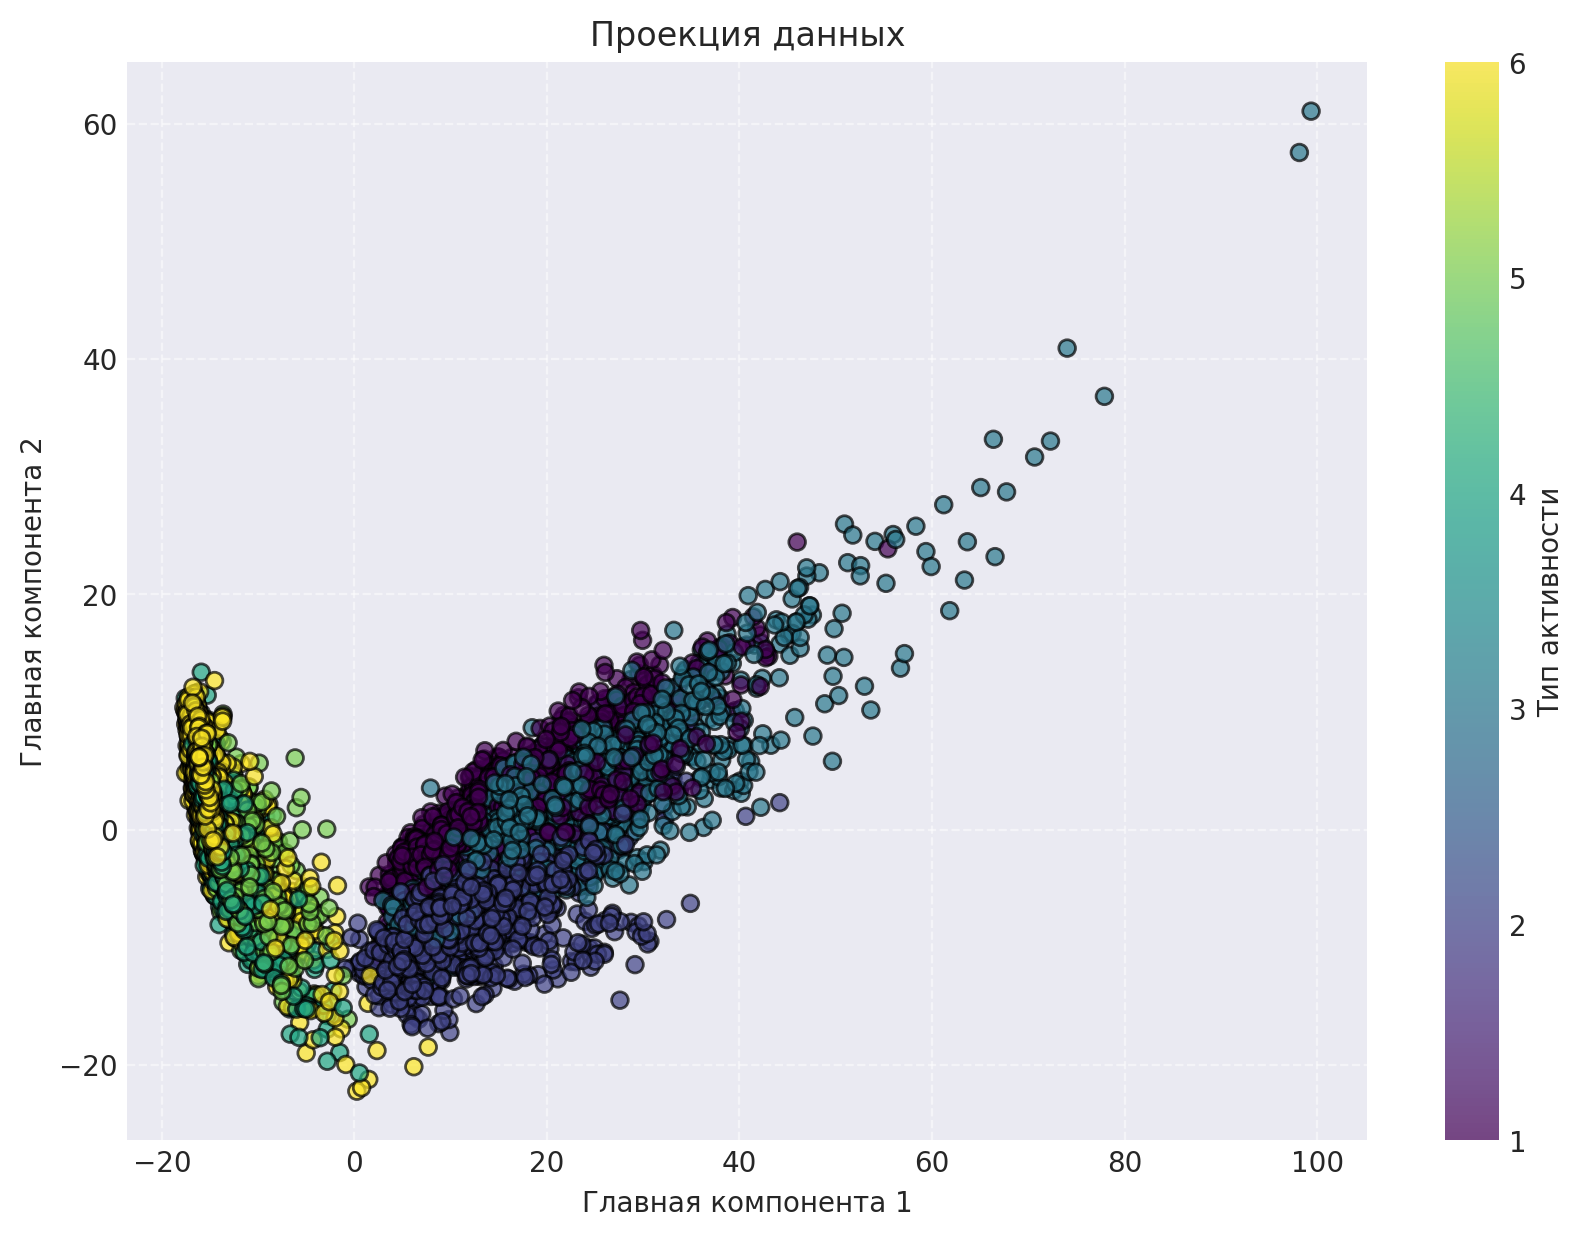

In [38]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.values.ravel(), cmap="viridis", alpha=0.7, edgecolors="k")
plt.colorbar(scatter, label="Тип активности")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.title("Проекция данных")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [39]:
# Инициализация модели
kmeans = KMeans(n_clusters=6, n_init=100, random_state=42)

# Засекаем время обучения
start_time = time.time()
kmeans.fit(X_pca)
training_time = time.time() - start_time

# Засекаем время предсказания
start_time = time.time()
clusters = kmeans.predict(X_pca)
prediction_time = time.time() - start_time

training_time, prediction_time

(10.712741374969482, 0.003557920455932617)

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

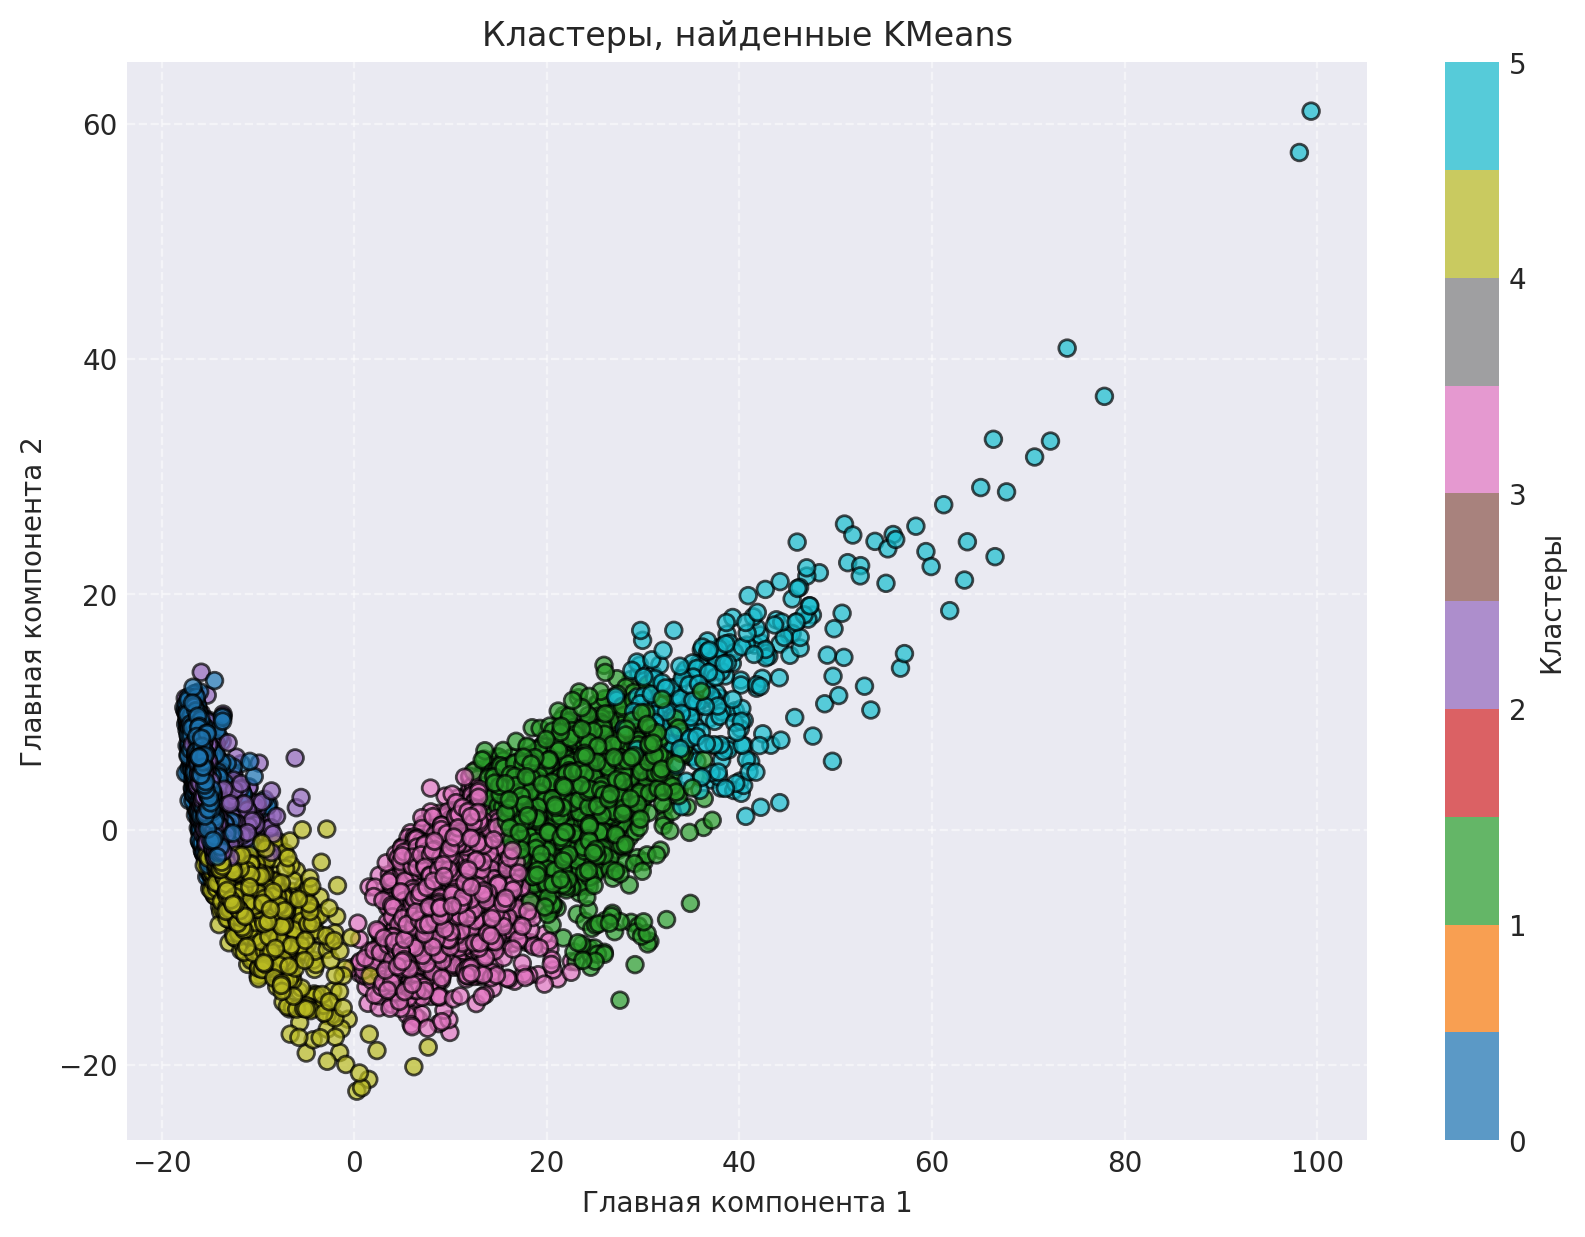

In [40]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="tab10", alpha=0.7, edgecolors="k")
plt.colorbar(scatter, label="Кластеры")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.title("Кластеры, найденные KMeans")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [41]:
# Вычисление метрик
ari = adjusted_rand_score(y.values.ravel(), clusters)
silhouette = silhouette_score(X_pca, clusters)

ari, silhouette

(0.4194956465790897, 0.14149759467581463)

Выбранные метрики:
1. Adjusted Rand Index (ARI) — показывает, насколько хорошо разбиение на кластеры совпадает с истинными метками. Значение от -1 до 1, где 1 — идеальное соответствие. Полученное значение (0.419) говорит о среднем качестве кластеризации, что означает, что модель нашла закономерности, но путаница между классами все еще значительна.
2. Silhouette Score — измеряет, насколько хорошо точки внутри кластера похожи друг на друга по сравнению с соседними кластерами. Значение от -1 до 1, где 1 — идеальное разделение. Полученное значение (0.141) довольно низкое, что указывает на наличие значительного пересечения между кластерами.

Вывод:
- Кластеризация уловила часть структуры данных, но классы сильно пересекаются.
- Можно попробовать другие методы кластеризации (например, DBSCAN) или улучшить предварительную обработку данных.


### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

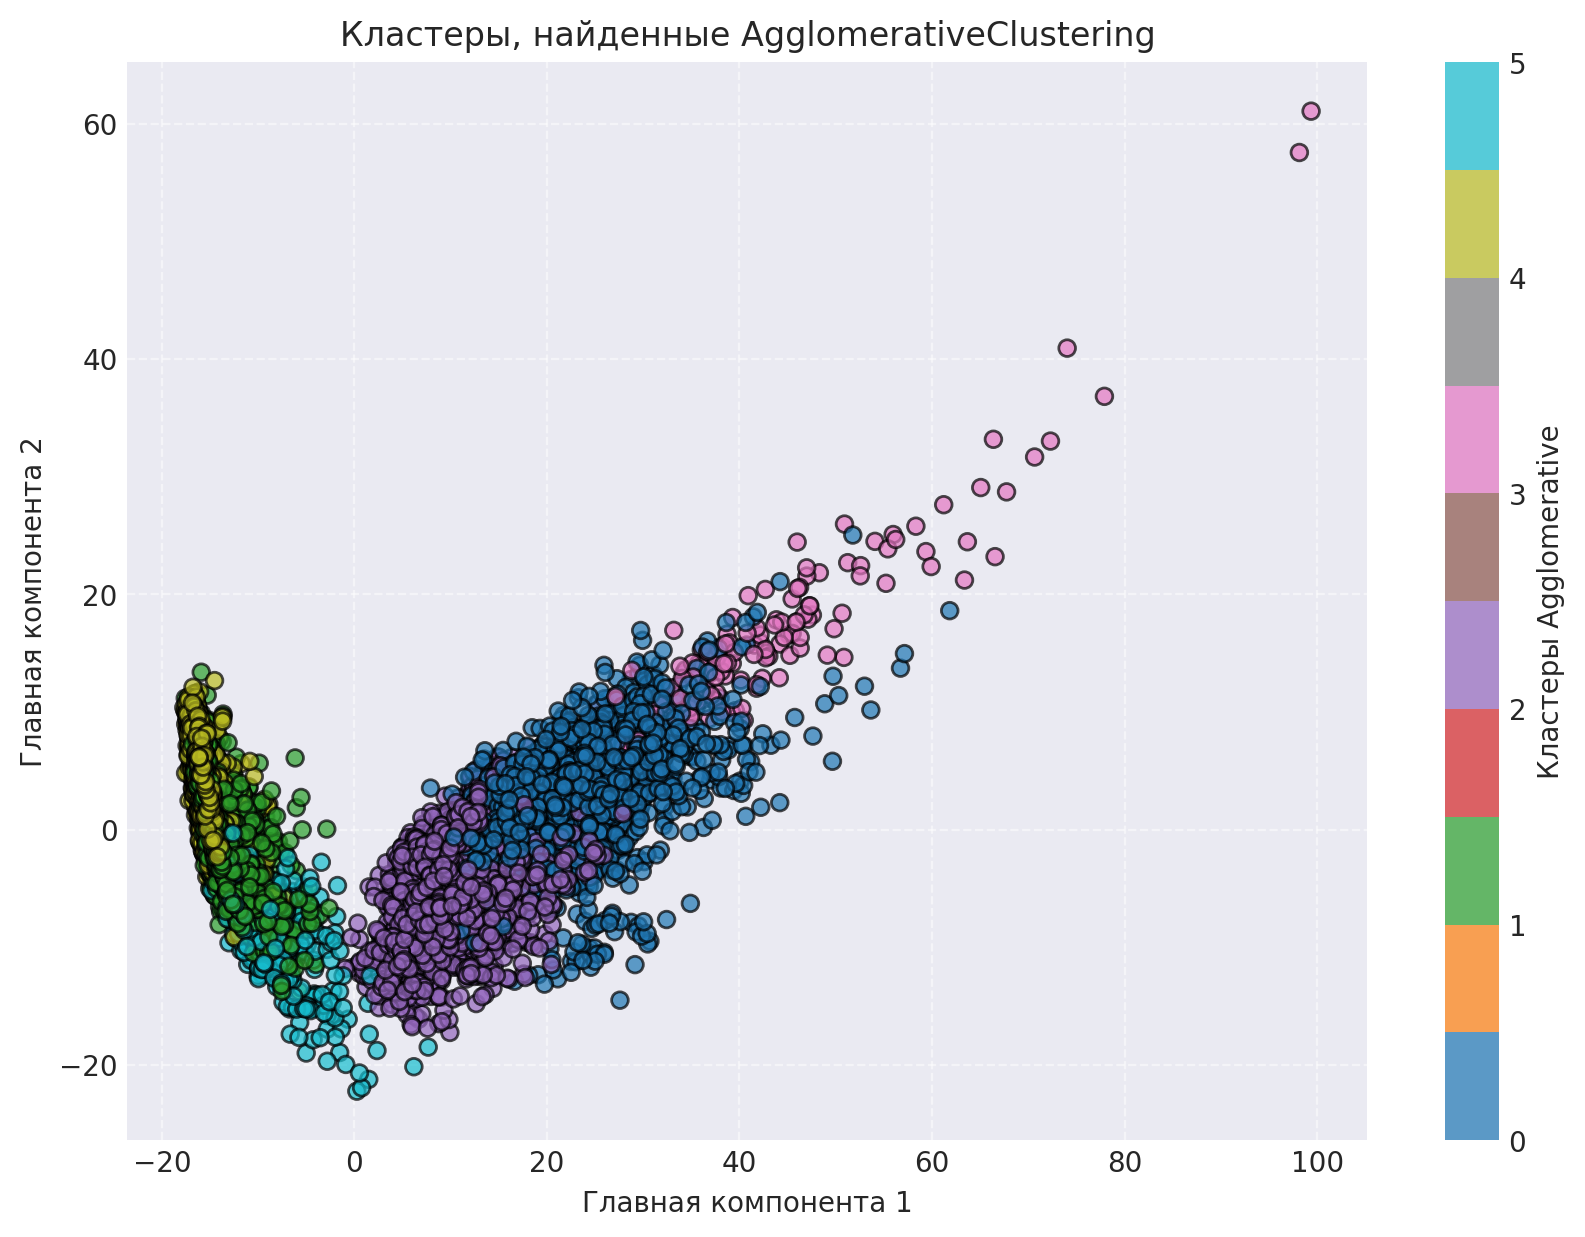

((7.916881084442139, 0.49362763373004886, 0.13658179879624432),
 (10.712741374969482, 0.4194956465790897, 0.14149759467581463))

In [42]:
# Инициализация модели
agg_clustering = AgglomerativeClustering(n_clusters=6)

# Засекаем время обучения
start_time = time.time()
clusters_agg = agg_clustering.fit_predict(X_pca)
training_time_agg = time.time() - start_time

# Визуализация результатов кластеризации
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_agg, cmap="tab10", alpha=0.7, edgecolors="k")
plt.colorbar(scatter, label="Кластеры Agglomerative")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.title("Кластеры, найденные AgglomerativeClustering")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Вычисление метрик
ari_agg = adjusted_rand_score(y.values.ravel(), clusters_agg)
silhouette_agg = silhouette_score(X_pca, clusters_agg)

# Сравнение времени работы и метрик с KMeans
(training_time_agg, ari_agg, silhouette_agg), (training_time, ari, silhouette)

1. Стало ли лучше?
- По значениям метрик ARI и силуэта результаты кластеризации с помощью AgglomerativeClustering (ARI = 0.49, Silhouette = 0.13) оказались немного лучше, чем у KMeans (ARI = 0.41, Silhouette = 0.14). Однако разница минимальна.

2. Почему?
- AgglomerativeClustering лучше справляется с данными, которые имеют более сложные формы кластеров или перекрытия, так как он не предполагает, что кластеры имеют сферическую форму, как это делает KMeans.
- Этот метод использует иерархический подход, что может быть полезно в случае сложных данных с ярко выраженной структурой.

3. Вывод:
- Учитывая небольшое улучшение качества и более длительное время работы AgglomerativeClustering, выбор алгоритма будет зависеть от требований задачи. Если скорость важнее, KMeans предпочтителен. Если важнее точность, AgglomerativeClustering может быть лучшим выбором.


### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

In [46]:
# Добавление кластеров к исходным данным для анализа
df_clusters = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])  # Используем только первые две главные компоненты
df_clusters["Cluster"] = clusters_agg
df_clusters["True_Label"] = y.values.ravel()

# Анализ распределения истинных меток внутри каждого кластера
cluster_analysis = df_clusters.groupby("Cluster")["True_Label"].value_counts(normalize=True).unstack()

# Вычисление доли объектов каждого типа активности в каждом кластере
cluster_summary = cluster_analysis.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Анализ распределения данных в каждом кластере
cluster_characteristics = df_clusters.groupby("Cluster")[["PC1", "PC2"]].describe()
cluster_characteristics

PC1                                                         \
          count       mean        std        min        25%        50%   
Cluster                                                                  
0        2281.0  21.772890   6.667444   5.489782  17.035667  21.123480   
1        3465.0 -14.196897   2.091793 -17.569751 -15.676075 -14.840906   
2        2241.0  10.485561   4.206505  -0.958403   7.430711  10.155667   
3         150.0  42.725480  12.194304  25.156607  35.133049  39.273629   
4        1675.0 -15.433958   1.435867 -17.719772 -16.404587 -15.812422   
5         487.0  -9.295273   4.248687 -15.258813 -12.358339 -10.306991   

                                  PC2                                  \
               75%        max   count       mean       std        min   
Cluster                                                                 
0        25.563331  61.836488  2281.0   1.708565  4.720714 -14.508376   
1       -13.299379  -2.638754  3465.0   0.914779  4.299625 -13.761141   
2        13.125380  27.873722  2241.0  -5.174612  4.228528 -17.249074   
3        46.306608  99.375195   150.0  16.271744  7.905994   6.971722   
4       -14.917444  -7.330160  1675.0   3.655345  3.747234  -9.144826   
5        -7.419725  13.242663   487.0  -8.283590  3.976947 -22.239898   

                                                     
               25%        50%        75%        max  
Cluster                                              
0        -1.257452   1.680871   4.543972  25.028615  
1        -1.958333   1.184333   4.200863  13.367845  
2        -8.061622  -5.367636  -2.230897   6.986211  
3        11.331005  14.610417  18.242935  61.053601  
4         0.761896   3.756855   6.685129  12.656683  
5       -10.430898  -7.576622  -5.473502   0.199284

In [48]:
# Добавление статистики по кластеру и виду активности
cluster_activity_stats = (
    df_clusters.groupby(["Cluster", "True_Label"])
    .agg(
        count=("PC1", "count"),
        mean_PC1=("PC1", "mean"),
        std_PC1=("PC1", "std"),
        mean_PC2=("PC2", "mean"),
        std_PC2=("PC2", "std")
    )
    .sort_index(level=[0, 1])
)

In [49]:
cluster_activity_stats

count   mean_PC1    std_PC1   mean_PC2   std_PC2
Cluster True_Label                                                  
0       1             800  20.812156   5.855214   4.041187  3.876358
        2             337  20.579605   5.677600  -3.146183  4.293735
        3            1144  22.796250   7.288401   1.507475  4.210963
1       4            1559 -14.683955   1.729648   1.779431  4.260842
        5            1832 -13.781618   2.280625   0.132184  4.197726
        6              74 -14.216756   1.981901   2.073196  3.885903
2       1             896  10.714661   3.885287  -1.628620  2.989851
        2            1207  10.441913   4.448206  -7.719104  3.129129
        3             138   9.379839   3.863592  -5.942768  2.808613
3       1              26  38.003130   5.432831  13.697857  4.000623
        3             124  43.715650  12.978148  16.811430  8.412494
4       4              71 -15.420915   1.418886   2.783969  2.521355
        6            1604 -15.434535   1.437049   3.693916  3.788268
5       4             147  -8.840673   3.563032 -10.182799  3.616792
        5              74  -9.791951   3.121927  -8.209233  2.885561
        6             266  -9.408326   4.819744  -7.254713  4.054685

На основе предоставленной статистики по кластерам и видам активности можно сделать следующие выводы:

1. Распределение объектов внутри кластеров:

Кластеры, такие как 0, содержат несколько типов активности (например, 1, 2, 3), что указывает на возможное пересечение данных.
Кластеры 3 и 4, похоже, связаны с более узким распределением, так как внутри них меньше активностей.

2. Статистические характеристики:

Средние значения (mean_PC1, mean_PC2) и стандартные отклонения дают информацию о плотности данных в кластерах.
Некоторые кластеры имеют более разбросанные значения (высокое std), что указывает на менее четкую структуру кластеров.

3. В каких кластерах смешано несколько типов активности?

Кластер 0 включает множество разных активностей, что может быть связано с перекрытием характеристик сигналов (например, схожими паттернами для ходьбы и подъема по лестнице).

4. Качественная ли получилась кластеризация?

Данные показывают, что кластеризация частично разделила активности, однако несколько кластеров содержат пересечения. Это указывает на возможность дальнейшего улучшения модели

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

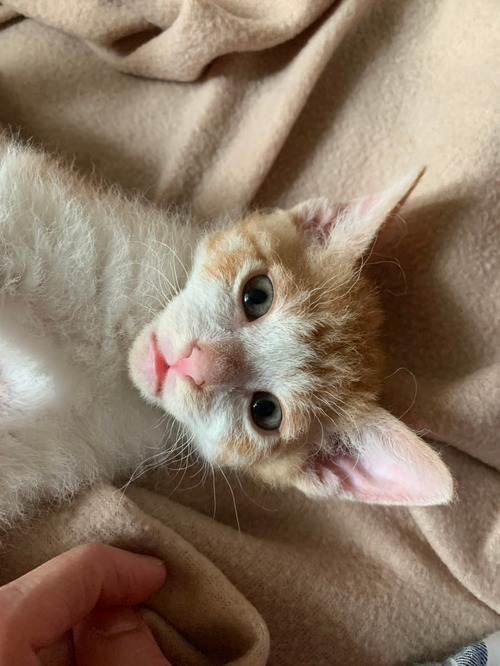